# Setup Empty Pipeline with Screen


In [1]:
# import resources
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume

# Create a screen for our Pipeline
universe = AverageDollarVolume(window_length=60) > 50000

# Create an empty Pipeline with the given screen
pipeline = Pipeline(screen=universe)

# Setup Zipline Engine

In [2]:
import helper
from zipline.utils.calendars import get_calendar
from zipline.data import bundles

# Name of bundle
EOD_BUNDLE_NAME = 'quantopian-quandl'

# Load the data bundle
bundle_data = bundles.load(EOD_BUNDLE_NAME)

# Setup the engine to look at the top 500 stocks who have had the highest rolling Average Dollar Volume
# over a 120-day window -- This is arbitrary and we can use this parameter to refine which stocks we
# want in our universe
universe = AverageDollarVolume(window_length=120).top(500) 

# Select the trading calendar that will be used as a reference when slicing the data
trading_calendar = get_calendar('NYSE') 

# Load the bundle we configured in the previous step into the engine
bundle_data = bundles.load(EOD_BUNDLE_NAME)

# Create the engine -- the details of this function are in the utils.py file
engine = helper.build_pipeline_engine(bundle_data, trading_calendar)

# View Pipeline as Graph

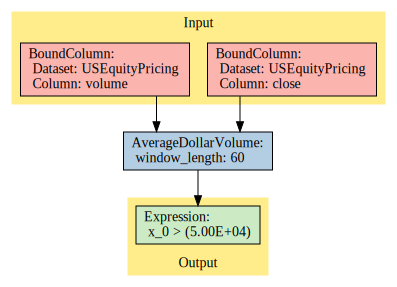

In [3]:
import graphviz

# Render the pipeline as a DAG
pipeline.show_graph()

# Run Pipeline Engine

In [4]:
import pandas as pd

# Set the start and end dates
start_date = pd.Timestamp('2016-01-05', tz = 'utc')
end_date = pd.Timestamp('2016-01-05', tz = 'utc')

# Run our pipeline for the given start and end dates
pipeline_output = engine.run_pipeline(pipeline, start_date, end_date)

# Get Universe Tickers

In [5]:
# Get the values in index level 1 and save them to a list
universe_tickers = pipeline_output.index.get_level_values(1).values.tolist()

# Create Data Portal

In [6]:
from zipline.data.data_portal import DataPortal

# Create a data portal
data_portal = DataPortal(bundle_data.asset_finder,
                         trading_calendar = trading_calendar,
                         first_trading_day = bundle_data.equity_daily_bar_reader.first_trading_day,
                         equity_daily_reader = bundle_data.equity_daily_bar_reader,
                         adjustment_reader = bundle_data.adjustment_reader)

# View Historical Data

Get the OHLC + V data for a given time period. This data will be split into individual dataframes.

In [7]:
def get_field_data(data_portal, trading_calendar, assets, start_date, end_date, field):
    
    # Set the given start and end dates to Timestamps. The frequency string C is used to
    # indicate that a CustomBusinessDay DateOffset is used
    end_dt = pd.Timestamp(end_date, tz='UTC', freq='C')
    start_dt = pd.Timestamp(start_date, tz='UTC', freq='C')

    # Get the locations of the start and end dates
    end_loc = trading_calendar.closes.index.get_loc(end_dt)
    start_loc = trading_calendar.closes.index.get_loc(start_dt)

    # return the historical data for the given window
    return data_portal.get_history_window(assets=assets, end_dt=end_dt, bar_count=end_loc - start_loc,
                                          frequency='1d',
                                          field=field,
                                          data_frequency='daily')

# The window of data to obtain
start_date = '2015-01-05'
end_data = '2016-01-05'

# Get the open data
open_data = get_field_data(data_portal, trading_calendar, universe_tickers,
                          start_date, end_date, 'open')

# Get the high data
high_data = get_field_data(data_portal, trading_calendar, universe_tickers,
                              start_date, end_date, 'high')

# Get the low data
low_data = get_field_data(data_portal, trading_calendar, universe_tickers,
                         start_date, end_date, 'low')

# Get the closing data
close_data = get_field_data(data_portal, trading_calendar, universe_tickers,
                              start_date, end_date, 'close') 

# Get the volume data
volume_data = get_field_data(data_portal, trading_calendar, universe_tickers,
                            start_date, end_date, 'volume')

# Combine OHLC dataframes into singular dataframe
Here we combine the four individual dataframes representing OHLC + V data into one historical dataframe.

In [12]:
import numpy as np

#Create dataframe and append blank row
historical_dfs = pd.DataFrame(columns=universe_tickers)
historical_dfs = historical_dfs.append(pd.Series([np.nan]), ignore_index=True)

# Loop through each universe ticker and create a combined dataframe for that ticker
for ticker in universe_tickers:
    # Get individual series representing the OHLCV data
    open_series = open_data[ticker]
    high_series = high_data[ticker]
    low_series = low_data[ticker]
    close_series = close_data[ticker]
    volume_series = volume_data[ticker]
    
    # Combine these series into 1 dataframe
    columns = ['open', 'high', 'low', 'close', 'volume']
    df = pd.concat([open_series,high_series, low_series, close_series, volume_series], axis=1)
    df.columns = columns    
    
    # Save this dataframe to historical_dfs
    historical_dfs[ticker] = pd.Series([df])
    
    
# Change the columns to be more human readable
columns = helper.beautify_tickers(universe_tickers)
historical_dfs.columns = columns

In [13]:
from pypf.instrument import DataframeInstrument
from pypf.chart import PFChart

# Set up dataframe instrument
df = historical_dfs['AAPL'][0]
df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
df['Date'] = df.index.astype(str)
df['Date'] = df['Date'].str.slice(0,10)
df['Volume'] = df['Volume'].astype(int)
dfi = DataframeInstrument('AAPL', dataframe=df)

# Create pf chart
chart = PFChart(dfi)

In [14]:
chart.create_chart()

In [15]:
print(chart.chart)


  AAPL  (2016-01-05 o: 105.75 h: 105.85 l: 102.41 c: 102.71)
  1.00% box, 3 box reversal, hl method
  signal: sell status: bear correction

 133.94|                                                                                                          |133.94
 132.61|                          x                                                                               |132.61
 131.30|                  x       x d     x       x                                                               |131.30
 130.00|                  x d     x d     x 6     x d                                                             |130.00
 128.71|                  x d     x d x   x d u   x d                                                             |128.71
 127.44|                  x d x   x d u d x d u d x d                                                             |127.44
 126.18|                  x o x d x o u d u o u d x d                                                             |126.18
 124.

In [ ]:
import importlib

importlib.reload(pypf)
importlib.reload(pypf.instrument)